In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)
#%cd '/content/drive/MyDrive/VOF_DIR/VOF/'

In [2]:
#!pip install nevergrad
#!pip install --pre -U pycaret
#!pip install darts

In [2]:
import vof
from vof import forecaster
from vof import optimizer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of 1st of Jan 2013 - 1st of Jan 2014 for the case study

In [4]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)

data.index = data.index.astype('datetime64[ns]')

data = data.loc['2013-01-01':'2014-01-01']

data.reset_index(inplace=True)

In [5]:
data['weekend'] = data.wday.isin([5,6])
data

date          item_id  sell_price  wday  snap_CA  snap_TX  \
0     2013-01-01      FOODS_1_004       1.780   4.0      1.0      1.0   
1     2013-01-02      FOODS_1_004       1.780   5.0      1.0      0.0   
2     2013-01-03      FOODS_1_004       1.780   6.0      1.0      1.0   
3     2013-01-04      FOODS_1_004       1.780   7.0      1.0      0.0   
4     2013-01-05      FOODS_1_004       1.780   1.0      1.0      1.0   
...          ...              ...         ...   ...      ...      ...   
36194 2013-12-28  HOUSEHOLD_1_521       0.961   1.0      0.0      0.0   
36195 2013-12-29  HOUSEHOLD_1_521       0.961   2.0      0.0      0.0   
36196 2013-12-30  HOUSEHOLD_1_521       0.961   3.0      0.0      0.0   
36197 2013-12-31  HOUSEHOLD_1_521       0.961   4.0      0.0      0.0   
36198 2014-01-01  HOUSEHOLD_1_521       0.961   5.0      1.0      1.0   

       snap_WI  sales  special_events      sin_wday  cos_wday  weekend  
0          0.0   69.0             1.0 -4.338837e-01 -0.900969    False  
1          1.0   81.0             0.0 -9.749279e-01 -0.222521     True  
2          1.0  110.0             0.0 -7.818315e-01  0.623490     True  
3          0.0   84.0             0.0 -2.449294e-16  1.000000    False  
4          1.0   98.0             0.0  7.818315e-01  0.623490    False  
...        ...    ...             ...           ...       ...      ...  
36194      0.0   40.0             0.0  7.818315e-01  0.623490    False  
36195      0.0   48.0             0.0  9.749279e-01 -0.222521    False  
36196      0.0   39.0             0.0  4.338837e-01 -0.900969    False  
36197      0.0   62.0             0.0 -4.338837e-01 -0.900969    False  
36198      0.0   51.0             1.0 -9.749279e-01 -0.222521     True  

[36199 rows x 12 columns]

In [6]:
data.corr()['sales']

sell_price       -0.049611
wday             -0.101907
snap_CA           0.052379
snap_TX           0.051091
snap_WI           0.057264
sales             1.000000
special_events   -0.009016
sin_wday          0.134154
cos_wday          0.047869
weekend          -0.087768
Name: sales, dtype: float64

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [7]:
top_items = data.groupby('item_id').sum().sort_values(by='sales').index[-3:-2]

alt.data_transformers.disable_max_rows()

alt.Chart(data.loc[data.item_id.isin(top_items)], title = 'Daily sales').mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [8]:
def get_input_item(item_id='FOODS_1_004'):
    item = data.loc[data.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

get_input_item(item_id='FOODS_1_004').head()

date      item_id  sell_price  wday  snap_CA  snap_TX  snap_WI  sales  \
0 2013-01-01  FOODS_1_004        1.78   4.0      1.0      1.0      0.0   69.0   
1 2013-01-02  FOODS_1_004        1.78   5.0      1.0      0.0      1.0   81.0   
2 2013-01-03  FOODS_1_004        1.78   6.0      1.0      1.0      1.0  110.0   
3 2013-01-04  FOODS_1_004        1.78   7.0      1.0      0.0      0.0   84.0   
4 2013-01-05  FOODS_1_004        1.78   1.0      1.0      1.0      1.0   98.0   

   special_events      sin_wday  cos_wday  weekend  
0             1.0 -4.338837e-01 -0.900969    False  
1             0.0 -9.749279e-01 -0.222521     True  
2             0.0 -7.818315e-01  0.623490     True  
3             0.0 -2.449294e-16  1.000000    False  
4             0.0  7.818315e-01  0.623490    False

In [9]:
def estimateSignificantLags(ts, nlags = 100, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[ 1  5  6 20 26 37 73 88 93 99]


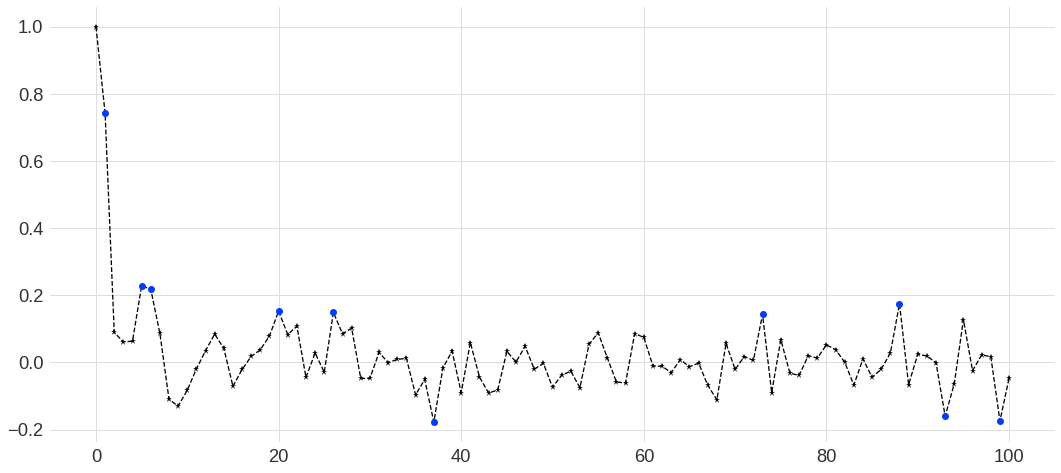

In [10]:
lags = estimateSignificantLags(get_input_item(item_id='HOUSEHOLD_1_110').sales, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

## Building prediction models

In [43]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates=None,
                             past_covariates=None,
                             model_display_name=None, 
                             past_covs = False,
                             future_covs = False):

    
    horizon = 3
    
    forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              past_covariates = past_covariates if past_covs else None,
                                              future_covariates = future_covariates if future_covs else None,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()
    #runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    start=time.time()
    
    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    end = time.time()
    res_df['runtime'] = (end-start)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*2)]
    else:
        return res_df
    #return res_df

In [44]:
[-i for i in range(1,8,1)]

[-1, -2, -3, -4, -5, -6, -7]

In [45]:
 def create_forecast_for_item(itemid, lags = [-1,-2,-52],lags_future_covariates=[0,1]):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    
    val_cols = ['sin_wday','cos_wday','special_events','snap_CA','snap_TX','snap_WI','weekend']
    
    external_covs = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=val_cols)
    
    
    # We first set aside the first 50% as training series:
    input_train, _ = input_timeseries.split_before(0.50)

    #Persistence
    naive_model_daily = NaiveSeasonal(K=1)
    naive_model_daily.fit(input_train)
    
    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    #Regression Models
    regr_model_2_lags =  RegressionModel(lags=[-i for i in range(1,3,1)])
    regr_model_2_lags.fit(input_train)

    regr_model_7_lags =  RegressionModel(lags=[-i for i in range(1,8,1)])
    regr_model_7_lags.fit(input_train)

    regr_model_14_lags =  RegressionModel(lags=[-i for i in range(1,15,1)])
    regr_model_14_lags.fit(input_train)

    regr_model_28_lags =  RegressionModel(lags=[-i for i in range(1,29,1)])
    regr_model_28_lags.fit(input_train)
                                               
    regr_model_cov_14_lags = RegressionModel(lags=[-i for i in range(1,15,1)],
                                     lags_past_covariates = [-i for i in range(1,15,1)],
                                     lags_future_covariates = lags_future_covariates)  
    regr_model_cov_14_lags.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)

    
    #LGBM Models
    lgbm_model_2_lags = LightGBMModel(lags=[-i for i in range(1,3,1)])
    lgbm_model_2_lags.fit(input_train)

    lgbm_model_7_lags = LightGBMModel(lags=[-i for i in range(1,8,1)])
    lgbm_model_7_lags.fit(input_train)
 
    lgbm_model_14_lags = LightGBMModel(lags=[-i for i in range(1,15,1)])
    lgbm_model_14_lags.fit(input_train)
    
    lgbm_model_28_lags = LightGBMModel(lags=[-i for i in range(1,29,1)])
    lgbm_model_28_lags.fit(input_train)
    """    
    lgbm_model_cov = LightGBMModel(lags = lags,
                                   lags_past_covariates = lags,
                                   lags_future_covariates = lags_future_covariates,
                                   n_estimators=100)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)
    """
    
    #Random Forest Models
    
    rf_model_2_lags = RandomForest(lags=[-i for i in range(1,3,1)],
                                   max_depth= 10,
                                   n_estimators=500)
    
    rf_model_2_lags.fit(input_train)
    
    rf_model_7_lags = RandomForest(lags=[-i for i in range(1,8,1)],
                                   max_depth= 10,
                                   n_estimators=500)
    
    rf_model_7_lags.fit(input_train)
    
    rf_model_14_lags = RandomForest(lags=[-i for i in range(1,15,1)],
                                   max_depth= 10,
                                   n_estimators=500)
    
    rf_model_14_lags.fit(input_train)
    
    
    rf_model_28_lags = RandomForest(lags=[-i for i in range(1,29,1)],
                                   max_depth= 10,
                                   n_estimators=500)
    
    rf_model_28_lags.fit(input_train)
    
    """rf_model_cov = RandomForest(lags=lags,
                                lags_past_covariates=lags,
                                lags_future_covariates = lags_future_covariates,
                               max_depth= 10, 
                               n_estimators=500)
    
    rf_model_cov.fit(input_train,
                     future_covariates = external_covs,
                       past_covariates = external_covs)

    """
    theta_model =  Theta(2,
                         season_mode=SeasonalityMode.ADDITIVE)
    
    theta_model.fit(input_train)
    
    
    models = {'Naive daily':[naive_model_daily,False,False],
              'Naive weekly':[naive_model_weekly,False,False],
              'Regression_2lags':[regr_model_2_lags,False,False],
              'Regression_7lags':[regr_model_7_lags,False,False],
              'Regression_14lags':[regr_model_14_lags,False,False],
              'Regression_28lags':[regr_model_28_lags,False,False],
              'LGBM_2lags':[lgbm_model_2_lags,False,False],
              'LGBM_7lags':[lgbm_model_7_lags,False,False],
              'LGBM_14lags':[lgbm_model_14_lags,False,False],
              'LGBM_28lags':[lgbm_model_28_lags,False,False],
              'RF_2lags':[rf_model_2_lags,False,False],
              'RF_7lags':[rf_model_7_lags,False,False],
              'RF_14lags':[rf_model_14_lags,False,False],
              'RF_28lags':[rf_model_14_lags,False,False],
              'RegressionModelCov':[regr_model_cov_14_lags,True,True],
              #'LGBM_cov':[lgbm_model_cov,True,True],
              #'RF_cov':[rf_model_cov,True,True],
              'Theta':[theta_model,False,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates = external_covs,
                                                             past_covariates = external_covs,
                                                             past_covs = models[model][1],
                                                             future_covs = models[model][2]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [46]:
optimization_df = create_forecast_for_item('FOODS_3_252',[-i for i in range(1,29,1)],lags_future_covariates=[1,2])

[2022-12-27 13:46:07,373] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
[2022-12-27 13:46:07,373] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    7.4s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   15.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed:   32.5s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   36.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  16 | elapsed:   39.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   40.3s remaining:   51.8s
[Parallel(n_jobs=-1)]: Done   8 out of  16 | elapsed:   40.8s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   44.8s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   48.9s remaining:   29.3s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   49.0s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapse

In [14]:
"""lags_by_item = {'FOODS_3_120':[-1,-6,-7,-13,-14,-18,-21], 
                'FOODS_3_587':[-1,-6,-7,-13,-14,-18,-21],
               'FOODS_3_252':[-1,-6,-7,-13,-14,-18,-21]
                }

optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item,lags_by_item[item],
                                                               lags_future_covariates=[1,2]) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df"""

"lags_by_item = {'FOODS_3_120':[-1,-6,-7,-13,-14,-18,-21], \n                'FOODS_3_587':[-1,-6,-7,-13,-14,-18,-21],\n               'FOODS_3_252':[-1,-6,-7,-13,-14,-18,-21]\n                }\n\noptimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)                            (delayed(create_forecast_for_item)(item,lags_by_item[item],\n                                                               lags_future_covariates=[1,2]) for item in top_items.values))\n\n#merge all items into a single dataframe\noptimization_df = pd.DataFrame()\nfor i in optimization_df_parallel:\n    optimization_df = optimization_df.append(i)\n\n    optimization_df"

In [19]:
optimization_df.head()

ts  value prediction_date        model   runtime      item_id
0 2013-03-02  288.0      2013-03-02  Naive daily  1.565005  FOODS_3_252
1 2013-03-03  288.0      2013-03-02  Naive daily  1.565005  FOODS_3_252
2 2013-03-04  288.0      2013-03-02  Naive daily  1.565005  FOODS_3_252
3 2013-03-05  288.0      2013-03-02  Naive daily  1.565005  FOODS_3_252
4 2013-03-06  288.0      2013-03-02  Naive daily  1.565005  FOODS_3_252

In [47]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']
#fact.loc[:,'FOODS_3_090',:].head()

In [48]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [49]:
alt.Chart(optimization_df).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    tooltip=['model:N','prediction_date:T','value:Q'],
    column='item_id:N'
).properties(width=600, height=400)#.interactive()

alt.Chart(...)

## Let's add some models based on noise

In [19]:
noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_10p'
noisy_biased_1p.value = 1.1*fact.value

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_20p'
noisy_biased_2p.value = 1.2*fact.value

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_30p'
noisy_biased_3p.value = 1.3*fact.value

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_40p'
noisy_biased_4p.value = 1.4*fact.value

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_10n'
noisy_biased_1n.value = 0.9*fact.value

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_20n'
noisy_biased_2n.value = 0.8*fact.value 

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_30n'
noisy_biased_3n.value = 0.7*fact.value

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_40n'
noisy_biased_4n.value = 0.6*fact.value

optimization_df = optimization_df.append(noisy_biased_1p)
optimization_df = optimization_df.append(noisy_biased_2p)
optimization_df = optimization_df.append(noisy_biased_3p)
optimization_df = optimization_df.append(noisy_biased_4p)
optimization_df = optimization_df.append(noisy_biased_1n)
optimization_df = optimization_df.append(noisy_biased_2n)
optimization_df = optimization_df.append(noisy_biased_3n)
optimization_df = optimization_df.append(noisy_biased_4n)

In [20]:
np.random.seed(42)

noisy_normal_0u_10p = fact.copy()
noisy_normal_0u_10p.model = 'noisy_normal_0u_10p'
noisy_normal_0u_10p.value = fact.value + np.random.uniform(-.1,.1)*fact.value

noisy_normal_0u_20p = fact.copy()
noisy_normal_0u_20p.model = 'noisy_normal_0u_20p'
noisy_normal_0u_20p.value = fact.value + np.random.uniform(-.2,.2)*fact.value

noisy_normal_0u_30p = fact.copy()
noisy_normal_0u_30p.model = 'noisy_normal_0u_30p'
noisy_normal_0u_30p.value = fact.value + np.random.uniform(-.3,.3)*fact.value

noisy_normal_0u_40p = fact.copy()
noisy_normal_0u_40p.model = 'noisy_normal_0u_40p'
noisy_normal_0u_40p.value = fact.value + np.random.uniform(-.4,.4)*fact.value

optimization_df = optimization_df.append(noisy_normal_0u_10p)
optimization_df = optimization_df.append(noisy_normal_0u_20p)
optimization_df = optimization_df.append(noisy_normal_0u_30p)
optimization_df = optimization_df.append(noisy_normal_0u_40p)

In [21]:
np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)

In [22]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact.head()

ts      item_id  value prediction_date model   runtime  \
0 2013-03-02  FOODS_3_252  390.0      2013-03-02  Fact  1.339218   
1 2013-03-03  FOODS_3_252  388.0      2013-03-03  Fact  1.339218   
2 2013-03-04  FOODS_3_252  244.0      2013-03-04  Fact  1.339218   
3 2013-03-05  FOODS_3_252  196.0      2013-03-05  Fact  1.339218   
4 2013-03-06  FOODS_3_252  241.0      2013-03-06  Fact  1.339218   

   time_since_prediction  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

In [23]:
np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)

### Evaluation function for all item_ids

In [50]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse rmse_normalized      item_id
0          Naive daily  115.834876        1.692941  FOODS_3_252
1         Naive weekly   68.422262             1.0  FOODS_3_252
2     Regression_2lags   91.436978        1.336363  FOODS_3_252
3     Regression_7lags   62.988849         0.92059  FOODS_3_252
4    Regression_14lags    58.56479        0.855932  FOODS_3_252
5    Regression_28lags   63.628905        0.929944  FOODS_3_252
6           LGBM_2lags   92.131468        1.346513  FOODS_3_252
7           LGBM_7lags   65.604576        0.958819  FOODS_3_252
8          LGBM_14lags   62.855058        0.918635  FOODS_3_252
9          LGBM_28lags   64.117549        0.937086  FOODS_3_252
10            RF_2lags    94.57265        1.382191  FOODS_3_252
11            RF_7lags   64.845196        0.947721  FOODS_3_252
12           RF_14lags   58.733349        0.858395  FOODS_3_252
13           RF_28lags   58.811011         0.85953  FOODS_3_252
14  RegressionModelCov    67.51272        0.986707  FOODS_3_252
15               Theta   54.914301        0.802579  FOODS_3_252
16                Fact         0.0             0.0  FOODS_3_252

In [51]:
alt.Chart(eval_df, title = 'RMSE by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N',
    tooltip = ['model:N','rmse']
).properties(width=400, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [52]:
items_prices = data.loc[data.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price
optimization_df

item_id         ts  value prediction_date        model   runtime  \
0      FOODS_3_252 2013-03-02  288.0      2013-03-02  Naive daily  1.566368   
1      FOODS_3_252 2013-03-03  288.0      2013-03-02  Naive daily  1.566368   
2      FOODS_3_252 2013-03-04  288.0      2013-03-02  Naive daily  1.566368   
3      FOODS_3_252 2013-03-03  390.0      2013-03-03  Naive daily  1.566368   
4      FOODS_3_252 2013-03-04  390.0      2013-03-03  Naive daily  1.566368   
...            ...        ...    ...             ...          ...       ...   
15397  FOODS_3_252 2013-12-28  296.0      2013-12-27         Fact  1.536491   
15398  FOODS_3_252 2013-12-29  236.0      2013-12-27         Fact  1.536491   
15399  FOODS_3_252 2013-12-28  296.0      2013-12-28         Fact  1.536491   
15400  FOODS_3_252 2013-12-29  236.0      2013-12-28         Fact  1.536491   
15401  FOODS_3_252 2013-12-30  177.0      2013-12-28         Fact  1.536491   

       sell_price  daily_revenue  
0            1.48         426.24  
1            1.48         426.24  
2            1.48         426.24  
3            1.48         577.20  
4            1.48         577.20  
...           ...            ...  
15397        1.48         438.08  
15398        1.48         349.28  
15399        1.48         438.08  
15400        1.48         349.28  
15401        1.48         261.96  

[15402 rows x 8 columns]

### Optimization target:
* Every day we make predictions for each item and calculate total profit for the day
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 20% of it's final price
* We implement a discount for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60%
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [53]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 3
        self.DECISION_TIMESTEP = 3
        self.MAX_CAPACITY = self.DECISION_TIMESTEP*(data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        self.ITEM_BASIC_PRICE = .2
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #3% increase in sales for each 1% increase in discount
        
        
        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        
        #if the projected value is higher than storage capacity, we only have as much as the storage is able to keep
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            self.candidate['value_w_disount'] = self.MAX_CAPACITY
            
            
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*self.ITEM_BASIC_PRICE)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*self.ITEM_BASIC_PRICE)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)
        
        #get all week beginnings from the prediction_date
        #total_steps = self.data.loc[self.data.prediction_date.dt.weekday==1,'prediction_date'].unique()
        
        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=100)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [54]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [55]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:  7.0min remaining: 52.8min
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:  7.1min remaining: 33.0min
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:  7.1min remaining: 23.0min
[Parallel(n_jobs=-1)]: Done   5 out of  17 | elapsed:  7.1min remaining: 17.0min
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:  7.1min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done   7 out of  17 | elapsed:  7.1min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:  7.1min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   9 out of  17 | elapsed:  7.1min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:  7.1min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:  7.1min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapse

In [56]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

#making decision every day, so we cut on the excessive data points here 
result_df = result_df.loc[result_df.prediction_date == result_df.ts]

## Evaluation of optimization based on Fact values

## Inventory:
 * After predicting the demand N with discount we'll stock N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (20%) is being deducted from the final profit

In [57]:
COST_PRICE = .2

result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*COST_PRICE)

result_df['inventory_left'] = result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*COST_PRICE
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*COST_PRICE

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

item_id prediction_date         ts              model       value  \
0  FOODS_3_252      2013-03-02 2013-03-02        Naive daily  288.000000   
1  FOODS_3_252      2013-03-02 2013-03-02       Naive weekly  360.000000   
2  FOODS_3_252      2013-03-02 2013-03-02   Regression_2lags  290.127771   
3  FOODS_3_252      2013-03-02 2013-03-02   Regression_7lags  359.009579   
4  FOODS_3_252      2013-03-02 2013-03-02  Regression_14lags  372.303345   

    runtime  sell_price  daily_revenue  disount  sell_price_w_disount  \
0  1.566368        1.48     426.240000      0.2                 1.184   
1  1.536491        1.48     532.800000      0.2                 1.184   
2  0.970177        1.48     429.389101      0.3                 1.036   
3  1.022989        1.48     531.334177      0.3                 1.036   
4  0.944904        1.48     551.008950      0.2                 1.184   

   value_increase  value_w_disount  daily_revenue_w_disount  daily_profit  \
0             0.6       460.800000               545.587200    340.992000   
1             0.6       576.000000               681.984000    426.240000   
2             0.9       551.242765               571.087505    343.511281   
3             0.9       682.118200               706.674455    425.067342   
4             0.6       595.685351               705.291456    440.807160   

   daily_profit_w_disount  value_fact  daily_profit_fact  \
0              409.190400       390.0             461.76   
1              511.488000       390.0             461.76   
2              407.919646       390.0             461.76   
3              504.767468       390.0             461.76   
4              528.968592       390.0             461.76   

   value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                 624.0                      554.112     -163.200000   
1                 624.0                      554.112      -48.000000   
2                 741.0                      548.340     -189.757235   
3                 741.0                      548.340      -58.881800   
4                 624.0                      554.112      -28.314649   

   final_profit_w_discount  final_profit_base_price  
0               360.883200               220.224000  
1               497.280000               390.720000  
2               351.751505               180.919293  
3               487.338455               374.614936  
4               520.587456               419.854320

In [58]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_df.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [59]:
discounts_freq = result_df.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

alt.Chart(...)

In [60]:
result_df.to_csv('results/ecomm_optimization_df.csv')

In [61]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [62]:
eval_df.set_index('model', inplace = True)
eval_df['runtime'] = optimization_df.groupby('model').max()['runtime']
eval_df.reset_index(inplace=True)

eval_df.head()

model      item_id        rmse rmse_normalized  \
0        Naive daily  FOODS_3_252  115.834876        1.692941   
1       Naive weekly  FOODS_3_252   68.422262             1.0   
2   Regression_2lags  FOODS_3_252   91.436978        1.336363   
3   Regression_7lags  FOODS_3_252   62.988849         0.92059   
4  Regression_14lags  FOODS_3_252    58.56479        0.855932   

   profit_increase_%   runtime  
0          -0.063267  1.566368  
1          -0.008263  1.536491  
2          -0.088686  0.970177  
3          -0.008432  1.022989  
4           0.002634  0.944904

In [63]:
eval_df['model_type'] = 'Actual'
eval_df.loc[eval_df.model.str.contains('noisy_'),'model_type'] = 'Simulation'
eval_df.loc[eval_df.model.str.contains('Fact'),'model_type'] = 'Fact' 
eval_df.loc[eval_df.model.str.contains('Naive'),'model_type'] = 'Persistence'

In [64]:
chart = alt.Chart(eval_df.loc[~eval_df.model.str.contains('noisy_')]).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model_type:N'),
    size = 'runtime',
    tooltip = ['model:N']
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'profit_increase_%': [eval_df.loc[eval_df.model == 'Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='profit_increase_%:Q')
zero_line = alt.Chart(pd.DataFrame({'profit_increase_%': [eval_df.loc[eval_df.model == 'Fact','profit_increase_%']*0]})).mark_rule(color='red').encode(y='profit_increase_%:Q')

chart + fact_line + zero_line

alt.LayerChart(...)

In [65]:
chart = alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model_type:N'),
    size = 'runtime',
    tooltip = ['model:N']
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'profit_increase_%': [eval_df.loc[eval_df.model == 'Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='profit_increase_%:Q')
zero_line = alt.Chart(pd.DataFrame({'profit_increase_%': [eval_df.loc[eval_df.model == 'Fact','profit_increase_%']*0]})).mark_rule(color='red').encode(y='profit_increase_%:Q')

chart + fact_line + zero_line

alt.LayerChart(...)

## Evaluation for all items in total

In [66]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']


In [67]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [68]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [69]:
all_items_eval.to_csv('results/ecomm_daily_opt_results.csv')